# **TEXT TO IMAGE GENERATION**


#### 1- takes input as text,

#### 2- convert the text to embedding using pre-trained character level embedding.

#### 3- Then give this embedding to Conditional Augmentation (CA) and

#### 4- then to Stage I Generator which gives us low-resolution 64*64 images.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **PREPROCESSING**

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

 CUB contains 200 bird species with 11,788 images. Since 80% of birds in this dataset have object-image size ratios of less than 0.5, as a pre-processing step, crop all images to ensure that bounding boxes of birds have greater-than-0.75 object-image size ratios.

DATA SET PREPARATION

In [ ]:
def number_of_images(root_dir):
    '''
    The function will return the number of images present in each
    subfolder, number of classes and total number of images.
    '''
    path_image = root_dir + '/images'

    image_subfolders = os.listdir(path_image)
    img = []
    species = []
    image_count = {}
    for image in image_subfolders:  #listing subfolders
        count = 0
        species.append(image)
        for ele in os.listdir(os.path.join(path_image, image)):  #listing images
            img.append(ele)
            jpg = str.split(ele,'.')
            for name in jpg:
                if name == 'jpg':
                    count=count+1
        image_count[image] = count

    return image_count,len(species),len(img)

number_of_bird_each_species, number_species,img_length = number_of_images('/content/drive/MyDrive/CUB_200_2011.tgz (Unzipped Files)/CUB_200_2011')

print('Total number of bird species: {}'.format(number_species))
print('Total number of images present: {}'.format(img_length))

Total number of bird species: 200
Total number of images present: 11788


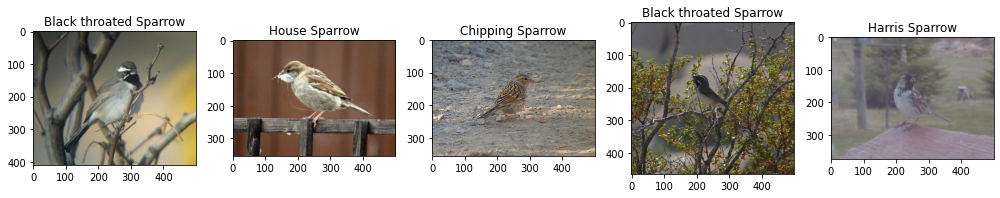

In [ ]:
import random
import matplotlib.image as mpimg

random.seed(42)
in_dir_data = '/content/drive/MyDrive/CUB_200_2011.tgz (Unzipped Files)/CUB_200_2011'
in_dir_img = os.path.join(in_dir_data, 'images')

# obtain classes of sparrow species
img_sparrows = dict()
cls_sparrows_total = [k for k in os.listdir(in_dir_img) if 'sparrow' in k.lower()]

# get images of some sparrow classes
cls_sparrows = cls_sparrows_total[1::2][:5]
for dirname in cls_sparrows:
    imgs = list()
    for dp, _, fn in os.walk(os.path.join(in_dir_img, dirname)):
        imgs.extend(fn)
    img_sparrows[dirname] = imgs

# visualize randomly-chosen images
n_cls = len(cls_sparrows)
f, ax = plt.subplots(1, n_cls, figsize=(14, 8))

for i in range(n_cls):
    cls_name = cls_sparrows[random.randint(0, n_cls - 1)]
    n_img = len(img_sparrows[cls_name])
    img_name = img_sparrows[cls_name][random.randint(0, n_img - 1)]
    path_img = os.path.join(os.path.join(in_dir_img, cls_name), img_name)
    ax[i].imshow(mpimg.imread(path_img))
    ax[i].set_title(cls_name.split('.')[-1].replace('_', ' '),  fontsize=12)

    plt.tight_layout()
plt.show()

**PRETRAINED EMBEDDING VECTOR**

char-CNN-RNN-embeddings.pickle — Dataframe for the pre-trained embeddings of the text.

filenames.pickle — Dataframe containing the filenames of the images.

class_info.pickle — Dataframe containing the info of classes for each image.

In [ ]:
def load_class_ids(class_info_file_path):
    """
    Load class ids from class_info.pickle file
    """
    with open(class_info_file_path, 'rb') as f: #read in binary mode.
        class_ids = pickle.load(f, encoding='latin1')
        return class_ids

def load_embeddings(embeddings_file_path):
    """
    Load embeddings
    """
    with open(embeddings_file_path, 'rb') as f:
        embeddings = pickle.load(f, encoding='latin1')
        embeddings = np.array(embeddings)
        print('embeddings: ', embeddings.shape)
    return embeddings

def load_filenames(filenames_file_path):
    """
    Load filenames.pickle file and return a list of all file names
    """
    with open(filenames_file_path, 'rb') as f:
        filenames = pickle.load(f, encoding='latin1')
    return filenames

def load_bounding_boxes(dataset_dir):
    """
    Load bounding boxes and return a dictionary of file names and corresponding bounding boxes
    """
    # Paths
    bounding_boxes_path = os.path.join(dataset_dir, 'bounding_boxes.txt')
    file_paths_path = os.path.join(dataset_dir, 'images.txt')

    # Read bounding_boxes.txt and images.txt file
    df_bounding_boxes = pd.read_csv(bounding_boxes_path,
                                    delim_whitespace=True, header=None).astype(int)
    df_file_names = pd.read_csv(file_paths_path, delim_whitespace=True, header=None)

    # Create a list of file names
    file_names = df_file_names[1].tolist()

    # Create a dictionary of file_names and bounding boxes
    filename_boundingbox_dict = {img_file[:-4]: [] for img_file in file_names[:2]}

    # Assign a bounding box to the corresponding image
    for i in range(0, len(file_names)):
        # Get the bounding box
        bounding_box = df_bounding_boxes.iloc[i][1:].tolist()
        key = file_names[i][:-4]
        filename_boundingbox_dict[key] = bounding_box

    return filename_boundingbox_dict
"""Crops the image to the bounding box and then resizes it.
	"""
def get_img(img_path, bbox, image_size):
    """
    Load and resize image
    """
    img = Image.open(img_path).convert('RGB')
    width, height = img.size
    if bbox is not None:
        R = int(np.maximum(bbox[2], bbox[3]) * 0.75)
        center_x = int((2 * bbox[0] + bbox[2]) / 2)
        center_y = int((2 * bbox[1] + bbox[3]) / 2)
        y1 = np.maximum(0, center_y - R)
        y2 = np.minimum(height, center_y + R)
        x1 = np.maximum(0, center_x - R)
        x2 = np.minimum(width, center_x + R)
        img = img.crop([x1, y1, x2, y2])
    img = img.resize(image_size, PIL.Image.BILINEAR)
    return img

def load_dataset(filenames_file_path, class_info_file_path, cub_dataset_dir, embeddings_file_path, image_size):
    """
    Load dataset
    """
    filenames = load_filenames(filenames_file_path)
    class_ids = load_class_ids(class_info_file_path)
    bounding_boxes = load_bounding_boxes(cub_dataset_dir)
    all_embeddings = load_embeddings(embeddings_file_path)

    X, y, embeddings = [], [], []

    print("Embeddings shape:", all_embeddings.shape)

    for index, filename in enumerate(filenames):
        bounding_box = bounding_boxes[filename]

        try:
            # Load images
            img_name = '{}/images/{}.jpg'.format(cub_dataset_dir, filename)
            img = get_img(img_name, bounding_box, image_size)

            all_embeddings1 = all_embeddings[index, :, :]

            embedding_ix = random.randint(0, all_embeddings1.shape[0] - 1)
            embedding = all_embeddings1[embedding_ix, :]

            X.append(np.array(img))
            y.append(class_ids[index])
            embeddings.append(embedding)
        except Exception as e:
            print(e)

    X = np.array(X)
    y = np.array(y)
    embeddings = np.array(embeddings)
    return X, y, embeddings

In [ ]:
data_dir = "/content/drive/MyDrive/Colab Notebooks/T2I/birds"
train_dir = data_dir + "/train"
test_dir = data_dir + "/test"
image_size = 64
embeddings_file_path_train = train_dir + "/char-CNN-RNN-embeddings.pickle"
embeddings_file_path_test = test_dir + "/char-CNN-RNN-embeddings.pickle"

filenames_file_path_train = train_dir + "/filenames.pickle"
filenames_file_path_test = test_dir + "/filenames.pickle"

class_info_file_path_train = train_dir + "/class_info.pickle"
class_info_file_path_test = test_dir + "/class_info.pickle"

cub_dataset_dir = "/content/drive/MyDrive/CUB_200_2011.tgz (Unzipped Files)/CUB_200_2011"


""""
Load datasets
"""
X_train, y_train, embeddings_train = load_dataset(filenames_file_path=filenames_file_path_train,
                                                  class_info_file_path=class_info_file_path_train,
                                                  cub_dataset_dir=cub_dataset_dir,
                                                  embeddings_file_path=embeddings_file_path_train,
                                                  image_size=(64, 64))

X_test, y_test, embeddings_test = load_dataset(filenames_file_path=filenames_file_path_test,
                                                class_info_file_path=class_info_file_path_test,
                                                cub_dataset_dir=cub_dataset_dir,
                                                embeddings_file_path=embeddings_file_path_test,
                                                image_size=(64, 64))

embeddings:  (8855, 10, 1024)
Embeddings shape: (8855, 10, 1024)
embeddings:  (2933, 10, 1024)
Embeddings shape: (2933, 10, 1024)


In [ ]:
def show_image(x):
    img = plt.figure()
    ax = img.add_subplot(1,1,1)
    ax.imshow(x)

Low resolution image with shape:  (64, 64, 3)


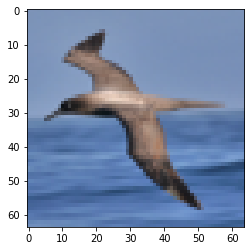

In [ ]:
print("Low resolution image with shape: ", X_train[88].shape)
show_image(X_train[88])

EXAMPLE CAPTION


---

this bird has a bright yellow body, with brown on its crown and wings.
this bird has a red breast and belly as well as a small bill.
small, roundish bird with off white breast and belly, light brown crown, brown and black colored wings.
A white bird with a black crown and yellow beak
the bird has gray crown, belly and white abdomen, with black tarsus and feet
a colorful bird with a bright yellow body, a black crown and throat, orange bill, and black primaries and secondaries.

In [ ]:
print("Embedding shape: ", embeddings_train[88].shape)
print("Embedding: ",embeddings_train[88])

Embedding shape:  (1024,)
Embedding:  [-0.02337656 -0.02753809  0.02730825 ...  0.08544552 -0.04683804
 -0.04683899]




---





---



REQUIREMENTS

In [ ]:
import os #'''which provides a way for the program to interact with the operating system.
#This module provides a portable way of using operating system
#dependent functionality like reading or writing to files, starting new processes, killing processes etc.'''

# get the current working directory
cwd = os.getcwd()
print(cwd)

/content


The "pickle" module in Python is used for serializing and deserializing Python objects. It allows you to convert a Python object into a byte stream, and vice versa. This allows you to save the state of a Python object to a file, or send it over a network, and then later recreate the object from the byte stream. The "pickle" module is part of the Python standard library, so you don't need to install any additional modules to use it.

In [ ]:
import pickle

In [ ]:
import random #The "random" module in Python provides a suite of functions for generating random numbers and selections

In [ ]:
import time #provides functions for working with time,

In [ ]:
import PIL #The PIL (Python Imaging Library) is a library that allows you to manipulate and work with image files in Python.

In [ ]:
import numpy as np #The numpy library, imported as "np", is a powerful tool for working with arrays and matrices of numerical data in Python.
import pandas as pd #powerful tool for working with data in Python.
import tensorflow as tf#TensorFlow is an open-source software library for machine learning ,for dataflow and differentiable programming across a range of tasks.
from PIL import Image
from keras import Input, Model
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.layers import Dense, LeakyReLU, BatchNormalization, ReLU, Reshape, UpSampling2D, Conv2D, Activation, \
    concatenate, Flatten, Lambda, Concatenate
from keras.optimizers import Adam
from matplotlib import pyplot as plt

In [ ]:
def load_class_ids(class_info_file_path):

    # Load class ids from class_info.pickle file #
   # These IDs are used to match the corresponding images in the dataset.
    with open(class_info_file_path, 'rb') as f: #read in binary mode.
        class_ids = pickle.load(f, encoding='latin1') #The encoding='latin1' parameter is used to specify the character encoding of the data stored in the pickle file.
        return class_ids

def load_embeddings(embeddings_file_path):
    """
    Load embeddings
    """
    with open(embeddings_file_path, 'rb') as f:
        embeddings = pickle.load(f, encoding='latin1')
        embeddings = np.array(embeddings)
        print('embeddings: ', embeddings.shape)
    return embeddings

def load_filenames(filenames_file_path):
    """
    Load filenames.pickle file and return a list of all file names
    """
    with open(filenames_file_path, 'rb') as f:
        filenames = pickle.load(f, encoding='latin1')
    return filenames

def load_bounding_boxes(dataset_dir):
    """
    Load bounding boxes and return a dictionary of file names and corresponding bounding boxes
    """
    # Paths
    bounding_boxes_path = os.path.join(dataset_dir, 'bounding_boxes.txt')
    file_paths_path = os.path.join(dataset_dir, 'images.txt')

    # Read bounding_boxes.txt and images.txt file
    df_bounding_boxes = pd.read_csv(bounding_boxes_path,
                                    delim_whitespace=True, header=None).astype(int)
    df_file_names = pd.read_csv(file_paths_path, delim_whitespace=True, header=None)

    # Create a list of file names
    file_names = df_file_names[1].tolist()

    # Create a dictionary of file_names and bounding boxes
    filename_boundingbox_dict = {img_file[:-4]: [] for img_file in file_names[:2]}

    # Assign a bounding box to the corresponding image
    for i in range(0, len(file_names)):
        # Get the bounding box
        bounding_box = df_bounding_boxes.iloc[i][1:].tolist()
        key = file_names[i][:-4]
        filename_boundingbox_dict[key] = bounding_box

    return filename_boundingbox_dict
"""Crops the image to the bounding box and then resizes it.
	"""
def get_img(img_path, bbox, image_size):
    """
    Load and resize image
    """
    img = Image.open(img_path).convert('RGB')
    width, height = img.size
    if bbox is not None:
        R = int(np.maximum(bbox[2], bbox[3]) * 0.75)
        center_x = int((2 * bbox[0] + bbox[2]) / 2)
        center_y = int((2 * bbox[1] + bbox[3]) / 2)
        y1 = np.maximum(0, center_y - R)
        y2 = np.minimum(height, center_y + R)
        x1 = np.maximum(0, center_x - R)
        x2 = np.minimum(width, center_x + R)
        img = img.crop([x1, y1, x2, y2])
    img = img.resize(image_size, PIL.Image.BILINEAR)
    return img

def load_dataset(filenames_file_path, class_info_file_path, cub_dataset_dir, embeddings_file_path, image_size):
    """
    Load dataset
    """
    filenames = load_filenames(filenames_file_path)
    class_ids = load_class_ids(class_info_file_path)
    bounding_boxes = load_bounding_boxes(cub_dataset_dir)
    all_embeddings = load_embeddings(embeddings_file_path)

    X, y, embeddings = [], [], []

    print("Embeddings shape:", all_embeddings.shape)

    for index, filename in enumerate(filenames):
        bounding_box = bounding_boxes[filename]

        try:
            # Load images
            img_name = '{}/images/{}.jpg'.format(cub_dataset_dir, filename)
            img = get_img(img_name, bounding_box, image_size)

            all_embeddings1 = all_embeddings[index, :, :]

            embedding_ix = random.randint(0, all_embeddings1.shape[0] - 1)
            embedding = all_embeddings1[embedding_ix, :]

            X.append(np.array(img))
            y.append(class_ids[index])
            embeddings.append(embedding)
        except Exception as e:
            print(e)

    X = np.array(X)
    y = np.array(y)
    embeddings = np.array(embeddings)
    return X, y, embeddings



---



---



## **EMBEDDING**

**Conditioning Augmentation Network**

Computer doesn’t understand words, but it can represent the words in terms of something it does “understand”. That’s the “text embedding”, and it’s used as the c

"""The mean_logsigma passed as argument is converted into the text conditioning variable.

	Args:
		x: The output of the text embedding passed through a FC layer with LeakyReLU non-linearity.

	Returns:
	 	c: The text conditioning variable after computation.
	"""

In [ ]:
def generate_c(x):
    mean = x[:, :128]
    log_sigma = x[:, 128:]
    stddev = K.exp(log_sigma)
    epsilon = K.random_normal(shape=K.constant((mean.shape[1],), dtype='int32'))
    c = stddev * epsilon + mean
    return c

def build_ca_model():
    """
    Get conditioning augmentation model.
    Takes an embedding of shape (1024,) and returns a tensor of shape (256,)
    """
    input_layer = Input(shape=(1024,))
    x = Dense(256)(input_layer)
    x = LeakyReLU(alpha=0.2)(x)
    model = Model(inputs=[input_layer], outputs=[x])
    return model

def build_embedding_compressor_model(): #lots of vocabulary...inorder to increse speed
    """
    Build embedding compressor model
    """
    input_layer = Input(shape=(1024,))
    x = Dense(128)(input_layer)
    x = ReLU()(x)

    model = Model(inputs=[input_layer], outputs=[x])
    return model





---



---



## **MODEL**

**Stage 1 Generator Network **

1. The generator is fed with the text captions in the form of Embedding vectors which will be used to condition its generation of features.
2. A vector with random noise.

	"""An Upsample block with Upsampling2D, Conv2D, BatchNormalization and a ReLU activation.

	Args:
		x: The preceding layer as input.
		num_kernels: Number of kernels for the Conv2D layer.

	Returns:
		x: The final activation layer after the Upsampling block.

In [ ]:

def build_stage1_generator():
    """
    Builds a generator model used in Stage-I
    """
    input_layer = Input(shape=(1024,)) #embedding vecor
    x = Dense(256)(input_layer) #Compressing text embedding...unless take too many time
    mean_logsigma = LeakyReLU(alpha=0.2)(x)

    c = Lambda(generate_c)(mean_logsigma) #CA

    input_layer2 = Input(shape=(100,)) #random noise of size 100....we can use different value

    gen_input = Concatenate(axis=1)([c, input_layer2]) #d dimensional array

    x = Dense(128 * 8 * 4 * 4, use_bias=False)(gen_input) #16384 neuron
    x = ReLU()(x) #4x4x1024=1024 is embedding vector shape

    x = Reshape((4, 4, 128 * 8), input_shape=(128 * 8 * 4 * 4,))(x) # low resolution4X4 to higher...start with low...algorithm learn simple problem first

    x = UpSampling2D(size=(2, 2))(x)  #double the size(rawXcolumn)  =512
    x = Conv2D(512, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x) #mod collapse...different input generater may provide same image
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)# 256
    x = Conv2D(256, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x) #128
    x = Conv2D(128, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x) #64 upsample our image to 64x64
    x = Conv2D(64, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(3, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = Activation(activation='tanh')(x)

    stage1_gen = Model(inputs=[input_layer, input_layer2], outputs=[x, mean_logsigma])
    return stage1_gen

In [ ]:
GENERATOR1=build_stage1_generator()
GENERATOR1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1024)]       0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 256)          262400      ['input_5[0][0]']                
                                                                                                  
 leaky_re_lu_12 (LeakyReLU)     (None, 256)          0           ['dense_2[0][0]']                
                                                                                                  
 lambda_2 (Lambda)              (None, 128)          0           ['leaky_re_lu_12[0][0]']         
                                                                                            

Stage 1 Discriminator Network

"""A ConvBlock with a Conv2D, BatchNormalization and LeakyReLU activation.

	Args:
		x: The preceding layer as input.
		num_kernels: Number of kernels for the Conv2D layer.

	Returns:
		x: The final activation layer after the ConvBlock block.
	"""

	"""Builds the Stage 1 Discriminator that uses the 64x64 resolution images from the generator
	and the compressed and spatially replicated embedding.

	Returns:
		Stage 1 Discriminator Model for StackGAN.
	"""

During training, the discriminator takes real images and their corresponding text description as a positive sample pair. Real images with mismatched text embeddings and synthetic image with their corresponding text embeddings are considered as negative sample pairs.

In [ ]:
# the discriminator is fed with two inputs, the feature from Generator and the text embedding
def build_stage1_discriminator():
    """
    Create a model which takes two inputs
    1. One from above network
    2. One from the embedding layer
    3. Concatenate along the axis dimension and feed it to the last module which produces final logits
    """
    input_layer = Input(shape=(64, 64, 3))

    x = Conv2D(64, (4, 4), #Downsampling...pooling layer or stride 2 reduce size
               padding='same', strides=2,
               input_shape=(64, 64, 3), use_bias=False)(input_layer)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
#obtain the compressed and spatially replicated text embedding
    input_layer2 = Input(shape=(4, 4, 128)) #text embedding #2nd input to discriminator,

    merged_input = concatenate([x, input_layer2])

    x2 = Conv2D(64 * 8, kernel_size=1,
                padding="same", strides=1)(merged_input)
    x2 = BatchNormalization()(x2)
    x2 = LeakyReLU(alpha=0.2)(x2)
    # Flatten and add a FC layer to predict.
    x2 = Flatten()(x2) #Discreminator is a classifier
    x2 = Dense(1)(x2) # 1 neuron because binary classification
    x2 = Activation('sigmoid')(x2)

    stage1_dis = Model(inputs=[input_layer, input_layer2], outputs=[x2])
    return stage1_dis


In [ ]:
DISCRIMINATOR1=build_stage1_discriminator()
DISCRIMINATOR1.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_34 (Conv2D)             (None, 32, 32, 64)   3072        ['input_7[0][0]']                
                                                                                                  
 leaky_re_lu_13 (LeakyReLU)     (None, 32, 32, 64)   0           ['conv2d_34[0][0]']              
                                                                                                  
 conv2d_35 (Conv2D)             (None, 16, 16, 128)  131072      ['leaky_re_lu_13[0][0]']         
                                                                                            

Stage 1 Adversarial Model  (Building a GAN)

Generator and discriminator are stacked together. Output of the former is the input of the latter.

	"""Stage 1 Adversarial model.

	Args:
		generator_model: Stage 1 Generator Model
		discriminator_model: Stage 1 Discriminator Model

	Returns:
		Adversarial Model.
	"""

In [ ]:
# Building GAN with Generator and Discriminator
def build_adversarial_model(gen_model, dis_model):
    input_layer = Input(shape=(1024,)) #embedding vector
    input_layer2 = Input(shape=(100,)) #random noise
    input_layer3 = Input(shape=(4, 4, 128)) #dicriminator output

    x, mean_logsigma = gen_model([input_layer, input_layer2])

    dis_model.trainable = False #not training discriminator here...training separately
    #because performace of dicriminator due to generator influence
    valid = dis_model([x, input_layer3]) #probabilities

    model = Model(inputs=[input_layer, input_layer2, input_layer3], outputs=[valid, mean_logsigma])
    return model

In [ ]:
ganstage1 = build_adversarial_model(GENERATOR1, DISCRIMINATOR1)
ganstage1.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 1024)]       0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 model_2 (Functional)           [(None, 64, 64, 3),  10270400    ['input_9[0][0]',                
                                 (None, 256)]                     'input_10[0][0]']               
                                                                                                  
 input_11 (InputLayer)          [(None, 4, 4, 128)]  0           []                         

In [ ]:
def KL_loss(y_true, y_pred):
    mean = y_pred[:, :128]
    logsigma = y_pred[:, :128]
    loss = -logsigma + .5 * (-1 + K.exp(2. * logsigma) + K.square(mean))
    loss = K.mean(loss)
    return loss


def custom_generator_loss(y_true, y_pred):
    # Calculate binary cross entropy loss
    return K.binary_crossentropy(y_true, y_pred)

In [ ]:
def save_rgb_img(img, path):
    """
    Save an rgb image
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("Image")

    plt.savefig(path)
    plt.close()

def write_log(callback, name, loss, batch_no):
    """
    Write training summary to TensorBoard
    """
    summary = tf.summary()
    summary_value = summary.value.add()
    summary_value.simple_value = loss
    summary_value.tag = name

    # with self.writer.as_default():

    #           tf.summary.scalar(name, loss)

    #           self.writer.flush()

    callback.writer.add_summary(summary, batch_no)
    callback.writer.flush()




---



---



### **TRAINING GAN 1**

In [ ]:

if __name__ == '__main__':
    data_dir = "/content/drive/MyDrive/Colab Notebooks/T2I/birds"
    train_dir = data_dir + "/train"
    test_dir = data_dir + "/test"
    image_size = 64
    #batch_size = 64
    batch_size = 16
    z_dim = 100
    stage1_generator_lr = 0.0002
    stage1_discriminator_lr = 0.0002
    stage1_lr_decay_step = 600
    #epochs = 1000
    epochs = 10
    condition_dim = 128

    embeddings_file_path_train = train_dir + "/char-CNN-RNN-embeddings.pickle"
    embeddings_file_path_test = test_dir + "/char-CNN-RNN-embeddings.pickle"

    filenames_file_path_train = train_dir + "/filenames.pickle"
    filenames_file_path_test = test_dir + "/filenames.pickle"

    class_info_file_path_train = train_dir + "/class_info.pickle"
    class_info_file_path_test = test_dir + "/class_info.pickle"

    cub_dataset_dir = "/content/drive/MyDrive/CUB_200_2011.tgz (Unzipped Files)/CUB_200_2011"

    # Define optimizers
    dis_optimizer = Adam(lr=stage1_discriminator_lr, beta_1=0.5, beta_2=0.999)
    gen_optimizer = Adam(lr=stage1_generator_lr, beta_1=0.5, beta_2=0.999)

    """"
    Load datasets
    """
    X_train, y_train, embeddings_train = load_dataset(filenames_file_path=filenames_file_path_train,
                                                      class_info_file_path=class_info_file_path_train,
                                                      cub_dataset_dir=cub_dataset_dir,
                                                      embeddings_file_path=embeddings_file_path_train,
                                                      image_size=(64, 64))

    X_test, y_test, embeddings_test = load_dataset(filenames_file_path=filenames_file_path_test,
                                                   class_info_file_path=class_info_file_path_test,
                                                   cub_dataset_dir=cub_dataset_dir,
                                                   embeddings_file_path=embeddings_file_path_test,
                                                   image_size=(64, 64))

    """
    Build and compile networks
    """
    ca_model = build_ca_model()
    ca_model.compile(loss="binary_crossentropy", optimizer="adam")

    stage1_dis = build_stage1_discriminator()
    stage1_dis.compile(loss='binary_crossentropy', optimizer=dis_optimizer)

    stage1_gen = build_stage1_generator()
    stage1_gen.compile(loss="mse", optimizer=gen_optimizer)

    embedding_compressor_model = build_embedding_compressor_model()
    embedding_compressor_model.compile(loss="binary_crossentropy", optimizer="adam")

    adversarial_model = build_adversarial_model(gen_model=stage1_gen, dis_model=stage1_dis)
    adversarial_model.compile(loss=['binary_crossentropy', KL_loss], loss_weights=[1, 2.0],
                              optimizer=gen_optimizer, metrics=None)

    tensorboard = TensorBoard(log_dir="/content/drive/MyDrive/Colab Notebooks/STACKGAN/logs/".format(time.time()))
    tensorboard.set_model(stage1_gen)
    tensorboard.set_model(stage1_dis)
    tensorboard.set_model(ca_model)
    tensorboard.set_model(embedding_compressor_model)

    # Generate an array containing real and fake values
    # Apply label smoothing as well
    real_labels = np.ones((batch_size, 1), dtype=float) * 0.9
    fake_labels = np.zeros((batch_size, 1), dtype=float) * 0.1

    for epoch in range(epochs):
        print("========================================")
        print("Epoch is:", epoch)
        print("Number of batches", int(X_train.shape[0] / batch_size))

        gen_losses = []
        dis_losses = []

        # Load data and train model
        number_of_batches = int(X_train.shape[0] / batch_size)
        for index in range(number_of_batches):
            print("Batch:{}".format(index+1))

            """
            Train the discriminator network
            """
            # Sample a batch of data
            z_noise = np.random.normal(0, 1, size=(batch_size, z_dim))
            image_batch = X_train[index * batch_size:(index + 1) * batch_size]
            embedding_batch = embeddings_train[index * batch_size:(index + 1) * batch_size]
            image_batch = (image_batch - 127.5) / 127.5

            # Generate fake images
            fake_images, _ = stage1_gen.predict([embedding_batch, z_noise], verbose=3)

            # Generate compressed embeddings
            compressed_embedding = embedding_compressor_model.predict_on_batch(embedding_batch)
            compressed_embedding = np.reshape(compressed_embedding, (-1, 1, 1, condition_dim))
            compressed_embedding = np.tile(compressed_embedding, (1, 4, 4, 1))

            dis_loss_real = stage1_dis.train_on_batch([image_batch, compressed_embedding],
                                                      np.reshape(real_labels, (batch_size, 1)))
            dis_loss_fake = stage1_dis.train_on_batch([fake_images, compressed_embedding],
                                                      np.reshape(fake_labels, (batch_size, 1)))
            dis_loss_wrong = stage1_dis.train_on_batch([image_batch[:(batch_size - 1)], compressed_embedding[1:]],
                                                       np.reshape(fake_labels[1:], (batch_size-1, 1)))

            d_loss = 0.5 * np.add(dis_loss_real, 0.5 * np.add(dis_loss_wrong, dis_loss_fake))

            print("d_loss_real:{}".format(dis_loss_real))
            print("d_loss_fake:{}".format(dis_loss_fake))
            print("d_loss_wrong:{}".format(dis_loss_wrong))
            print("d_loss:{}".format(d_loss))

            """
            Train the generator network
            """
            g_loss = adversarial_model.train_on_batch([embedding_batch, z_noise, compressed_embedding],[K.ones((batch_size, 1)) * 0.9, K.ones((batch_size, 256)) * 0.9])
            print("g_loss:{}".format(g_loss))

            dis_losses.append(d_loss)
            gen_losses.append(g_loss)

        """
        Save losses to Tensorboard after each epoch

        """

       # write_log(tensorboard, 'discriminator_loss', np.mean(dis_losses), epoch)
       # write_log(tensorboard, 'generator_loss', np.mean(gen_losses[0]), epoch)

        # Generate and save images after every 2nd epoch
        if epoch % 2 == 0:
            # z_noise2 = np.random.uniform(-1, 1, size=(batch_size, z_dim))
            z_noise2 = np.random.normal(0, 1, size=(batch_size, z_dim))
            embedding_batch = embeddings_test[0:batch_size]
            fake_images, _ = stage1_gen.predict_on_batch([embedding_batch, z_noise2])
                  #/content/drive/MyDrive/Colab Notebooks/STACKGAN/results
            # Save images
            for i, img in enumerate(fake_images[:10]):
                save_rgb_img(img, "/content/drive/MyDrive/Colab Notebooks/STACKGAN/results/gen_{}_{}.png".format(epoch, i))

    # Save models
    stage1_gen.save_weights("/content/drive/MyDrive/Colab Notebooks/STACKGAN/stage1_gen.h5")
    stage1_dis.save_weights("/content/drive/MyDrive/Colab Notebooks/STACKGAN/stage1_dis.h5")

embeddings:  (8855, 10, 1024)
Embeddings shape: (8855, 10, 1024)
embeddings:  (2933, 10, 1024)
Embeddings shape: (2933, 10, 1024)
Epoch is: 0
Number of batches 553
Batch:1
d_loss_real:0.8778436183929443
d_loss_fake:2.0212039947509766
d_loss_wrong:7.918834209442139
d_loss:2.923931360244751
g_loss:[0.7277961373329163, 0.700028121471405, 0.013884017243981361]
Batch:2
d_loss_real:1.2797207832336426
d_loss_fake:0.8379846215248108
d_loss_wrong:1.3444420099258423
d_loss:1.1854670494794846
g_loss:[0.7613915205001831, 0.7338792681694031, 0.013756120577454567]
Batch:3
d_loss_real:3.296912670135498
d_loss_fake:0.39525651931762695
d_loss_wrong:1.7392116785049438
d_loss:2.1820733845233917
g_loss:[0.7722733020782471, 0.7474044561386108, 0.012434413656592369]
Batch:4
d_loss_real:3.2747864723205566
d_loss_fake:0.010303839109838009
d_loss_wrong:1.7715775966644287
d_loss:2.082863595103845
g_loss:[0.774459719657898, 0.7526004314422607, 0.010929632931947708]
Batch:5
d_loss_real:3.1425204277038574
d_loss_f

g_loss:[0.43524426221847534, 0.40648579597473145, 0.014379232190549374]


Streaming output truncated to the last 5000 lines.
d_loss_fake:0.0003467912320047617
d_loss_wrong:0.6967015862464905
d_loss:0.5696543930680491
g_loss:[0.5947365760803223, 0.5707105398178101, 0.012013012543320656]
Batch:274
d_loss_real:0.9049596786499023
d_loss_fake:0.00022235240612644702
d_loss_wrong:0.6742817163467407
d_loss:0.621105856513168
g_loss:[0.5485904216766357, 0.5237985253334045, 0.012395947240293026]
Batch:275
d_loss_real:0.8691890239715576
d_loss_fake:0.000742397562135011
d_loss_wrong:0.6598895788192749
d_loss:0.5997525060811313
g_loss:[0.4415643811225891, 0.41212379932403564, 0.014720294624567032]
Batch:276
d_loss_real:0.8162676692008972
d_loss_fake:0.0015282644890248775
d_loss_wrong:0.7005596160888672
d_loss:0.5836558047449216
g_loss:[0.4385303258895874, 0.40914207696914673, 0.014694126322865486]
Batch:277
d_loss_real:0.7655594944953918
d_loss_fake:0.00011637456191238016
d_loss_wrong:0.5868662595748901
d_loss:0.5295254057818966
g_loss:[0.5046175122261047, 0.4778166115283

d_loss_real:0.8664509654045105
d_loss_fake:5.600018266704865e-05
d_loss_wrong:0.6067943572998047
d_loss:0.5849380720728732
g_loss:[0.6524040102958679, 0.6478403806686401, 0.0022818041034042835]


Streaming output truncated to the last 5000 lines.
d_loss_real:0.8379409909248352
d_loss_fake:3.269032094976865e-05
d_loss_wrong:0.6558983325958252
d_loss:0.5829532511916113
g_loss:[0.6410124897956848, 0.6399517059326172, 0.0005303784855641425]
Batch:275
d_loss_real:0.8387049436569214
d_loss_fake:6.303514237515628e-05
d_loss_wrong:0.6430413126945496
d_loss:0.5801285587876919
g_loss:[0.6229369640350342, 0.6218396425247192, 0.0005486643640324473]
Batch:276
d_loss_real:0.8196228742599487
d_loss_fake:5.041787153459154e-05
d_loss_wrong:0.6701980233192444
d_loss:0.5773735474276691
g_loss:[0.6303967237472534, 0.629377543926239, 0.0005095937522128224]
Batch:277
d_loss_real:0.7913012504577637
d_loss_fake:3.34270516759716e-05
d_loss_wrong:0.6159963011741638
d_loss:0.5496580572853418
g_loss:[0.6074750423431396, 0.6065077781677246, 0.00048363939276896417]
Batch:278
d_loss_real:0.8474942445755005
d_loss_fake:5.237221557763405e-05
d_loss_wrong:0.6519390940666199
d_loss:0.5867449888582996
g_loss:[0.5

Streaming output truncated to the last 5000 lines.
d_loss_real:0.8483004570007324
d_loss_fake:0.00042010616743937135
d_loss_wrong:0.7037227749824524
d_loss:0.6001859487878392
g_loss:[0.5631275773048401, 0.5629333257675171, 9.71116460277699e-05]
Batch:275
d_loss_real:0.823578953742981
d_loss_fake:0.000569239491596818
d_loss_wrong:0.6682965755462646
d_loss:0.5790059306309558
g_loss:[0.6627098321914673, 0.6625126600265503, 9.859182318905368e-05]
Batch:276
d_loss_real:0.8130894899368286
d_loss_fake:0.00029974128119647503
d_loss_wrong:0.6257151365280151
d_loss:0.5630484644207172
g_loss:[0.6177282333374023, 0.6174921989440918, 0.00011802592052845284]
Batch:277
d_loss_real:0.8248046040534973
d_loss_fake:0.00013702204159926623
d_loss_wrong:0.6249369382858276
d_loss:0.5686707921086054
g_loss:[0.5658215284347534, 0.565659761428833, 8.088213508017361e-05]
Batch:278
d_loss_real:0.7874375581741333
d_loss_fake:0.00015385806909762323
d_loss_wrong:0.64066481590271
d_loss:0.5539234475800185
g_loss:[0.5

Streaming output truncated to the last 5000 lines.
d_loss_real:0.8345898389816284
d_loss_fake:1.0031212696048897e-05
d_loss_wrong:0.6597282290458679
d_loss:0.5822294845554552
g_loss:[0.6446623206138611, 0.644400954246521, 0.00013067867257632315]
Batch:275
d_loss_real:0.8262649774551392
d_loss_fake:3.1040297471918166e-05
d_loss_wrong:0.6725369691848755
d_loss:0.5812744910981564
g_loss:[0.6460719704627991, 0.645803689956665, 0.00013413120177574456]
Batch:276
d_loss_real:0.7948403358459473
d_loss_fake:2.4520142687833868e-05
d_loss_wrong:0.6307600736618042
d_loss:0.5551163163740966
g_loss:[0.6365233063697815, 0.6362556219100952, 0.00013384519843384624]
Batch:277
d_loss_real:0.8090634942054749
d_loss_fake:2.3963360945344903e-05
d_loss_wrong:0.6325300931930542
d_loss:0.5626702612412373
g_loss:[0.6039754748344421, 0.6037497520446777, 0.00011285651999060065]
Batch:278
d_loss_real:0.7801743745803833
d_loss_fake:1.850003536674194e-05
d_loss_wrong:0.6433068513870239
d_loss:0.5509185251457893
g_lo

Epoch is: 9
Number of batches 553
Batch:1
d_loss_real:0.8362862467765808
d_loss_fake:0.0003480101004242897
d_loss_wrong:0.6146283745765686
d_loss:0.5718872195575386
g_loss:[0.5815626978874207, 0.5812562704086304, 0.00015320396050810814]
Batch:2
d_loss_real:0.8045586347579956
d_loss_fake:0.0001627310848562047
d_loss_wrong:0.6604147553443909
d_loss:0.5674236889863096
g_loss:[0.5831383466720581, 0.5827822089195251, 0.0001780605234671384]
Batch:3
d_loss_real:0.8136744499206543
d_loss_fake:0.0002024972200160846
d_loss_wrong:0.6233583092689514
d_loss:0.562727426582569
g_loss:[0.6425556540489197, 0.6422098278999329, 0.00017291841504629701]
Batch:4
d_loss_real:0.8193129301071167
d_loss_fake:0.000376063835574314
d_loss_wrong:0.6944531798362732
d_loss:0.5833637759715202
g_loss:[0.6338449716567993, 0.633520245552063, 0.00016234976646956056]
Batch:5
d_loss_real:0.8121628761291504
d_loss_fake:0.00023387381224893034
d_loss_wrong:0.6364250779151917
d_loss:0.5652461759964353
g_loss:[0.7460823059082031

In [ ]:
def show_image(x):
    img = plt.figure()
    ax = img.add_subplot(1,1,1)
    ax.imshow(x)

Low resolution image 


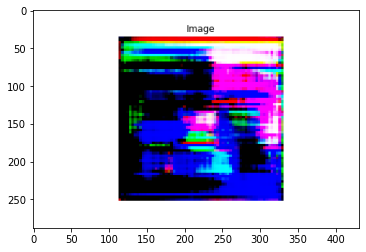

In [ ]:
GAN1_output="/content/drive/MyDrive/Colab Notebooks/STACKGAN/results/gen_8_9.png"
print("Low resolution image ")
# show_image(GAN1_output)
img=Image.open(GAN1_output)
plt.imshow(img)
plt.show()


# **Stage 2 Generator**

In [ ]:
import os
import pickle
import random
import time

import PIL
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from keras import Input, Model
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.layers import Dense, LeakyReLU, BatchNormalization, ReLU, Reshape, UpSampling2D, Conv2D, Activation, \
    concatenate, Flatten, Lambda, Concatenate, ZeroPadding2D
from keras.layers import add
from keras.optimizers import Adam
from matplotlib import pyplot as plt

In [ ]:

def build_ca_model():
    """
    Get conditioning augmentation model.
    Takes an embedding of shape (1024,) and returns a tensor of shape (256,)
    """
    input_layer = Input(shape=(1024,))
    x = Dense(256)(input_layer)
    x = LeakyReLU(alpha=0.2)(x)
    model = Model(inputs=[input_layer], outputs=[x])
    return model

def build_embedding_compressor_model():
    """
    Build embedding compressor model
    """
    input_layer = Input(shape=(1024,))
    x = Dense(128)(input_layer)
    x = ReLU()(x)
    model = Model(inputs=[input_layer], outputs=[x])
    return model

In [ ]:

def generate_c(x):
    mean = x[:, :128]
    log_sigma = x[:, 128:]

    stddev = K.exp(log_sigma)
    epsilon = K.random_normal(shape=K.constant((mean.shape[1],), dtype='int32'))
    c = stddev * epsilon + mean

    return c

def build_stage1_generator():
    """
    Builds a generator model used in Stage-I
    """
    input_layer = Input(shape=(1024,))
    x = Dense(256)(input_layer)
    mean_logsigma = LeakyReLU(alpha=0.2)(x)

    c = Lambda(generate_c)(mean_logsigma)

    input_layer2 = Input(shape=(100,))

    gen_input = Concatenate(axis=1)([c, input_layer2])

    x = Dense(128 * 8 * 4 * 4, use_bias=False)(gen_input)
    x = ReLU()(x)

    x = Reshape((4, 4, 128 * 8), input_shape=(128 * 8 * 4 * 4,))(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(512, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(3, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = Activation(activation='tanh')(x)

    stage1_gen = Model(inputs=[input_layer, input_layer2], outputs=[x, mean_logsigma])
    return stage1_gen

In [ ]:
generator1 = build_stage1_generator()
generator1.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 1024)]       0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 256)          262400      ['input_15[0][0]']               
                                                                                                  
 leaky_re_lu_18 (LeakyReLU)     (None, 256)          0           ['dense_5[0][0]']                
                                                                                                  
 lambda_3 (Lambda)              (None, 128)          0           ['leaky_re_lu_18[0][0]']         
                                                                                            

"""Residual block with plain identity connections.

	Args:
		inputs: input layer or an encoded layer

	Returns:
		Layer with computed identity mapping.
	"""

In [ ]:

def residual_block(input):
    """
    Residual block in the generator network
    """
    x = Conv2D(128 * 4, kernel_size=(3, 3), padding='same', strides=1)(input)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(128 * 4, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    x = add([x, input])
    x = ReLU()(x)

    return x

	"""Joins the conditioned text with the encoded image along the dimensions.

	Args:
		inputs: consisting of conditioned text and encoded images as [c,x].

	Returns:
		Joint block along the dimensions.
	"""

In [ ]:

def joint_block(inputs):
    c = inputs[0]
    x = inputs[1]

    c = K.expand_dims(c, axis=1)
    c = K.expand_dims(c, axis=1)
    c = K.tile(c, [1, 16, 16, 1])
    return K.concatenate([c, x], axis=3)

def build_stage2_generator():
    """
    Create Stage-II generator containing the CA Augmentation Network,
    the image encoder and the generator network
    """

    # 1. CA Augmentation Network
    input_layer = Input(shape=(1024,))
    input_lr_images = Input(shape=(64, 64, 3))

    ca = Dense(256)(input_layer)
    mean_logsigma = LeakyReLU(alpha=0.2)(ca)
    c = Lambda(generate_c)(mean_logsigma)

    # 2. Image Encoder
    x = ZeroPadding2D(padding=(1, 1))(input_lr_images)
    x = Conv2D(128, kernel_size=(3, 3), strides=1, use_bias=False)(x)
    x = ReLU()(x)

    x = ZeroPadding2D(padding=(1, 1))(x)
    x = Conv2D(256, kernel_size=(4, 4), strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = ZeroPadding2D(padding=(1, 1))(x)
    x = Conv2D(512, kernel_size=(4, 4), strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
	# Concatenate text conditioning block with the encoded image
    # 3. Joint
    c_code = Lambda(joint_block)([c, x])

    x = ZeroPadding2D(padding=(1, 1))(c_code)
    x = Conv2D(512, kernel_size=(3, 3), strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # 4. Residual blocks
    x = residual_block(x)
    x = residual_block(x)
    x = residual_block(x)
    x = residual_block(x)

    # 5. Upsampling blocks
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(512, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(3, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = Activation('tanh')(x)

    model = Model(inputs=[input_layer, input_lr_images], outputs=[x, mean_logsigma])
    return model



In [ ]:
generator_stage2 = build_stage2_generator()
generator_stage2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 66, 66, 3)   0           ['input_2[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 128)  3456        ['zero_padding2d[0][0]']         
                                                                                                  
 re_lu (ReLU)                   (None, 64, 64, 128)  0           ['conv2d[0][0]']                 
                                                                                              

Stage 2 Discriminator Network

	"""Builds the Stage 2 Discriminator that uses the 256x256 resolution images from the generator
	and the compressed and spatially replicated embeddings.

	Returns:
		Stage 2 Discriminator Model for StackGAN.
	"""

In [ ]:
def build_stage2_discriminator():
    """
    Create Stage-II discriminator network
    """
    input_layer = Input(shape=(256, 256, 3))

    x = Conv2D(64, (4, 4), padding='same', strides=2, input_shape=(256, 256, 3), use_bias=False)(input_layer)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(1024, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(2048, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(1024, (1, 1), padding='same', strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, (1, 1), padding='same', strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)

    x2 = Conv2D(128, (1, 1), padding='same', strides=1, use_bias=False)(x)
    x2 = BatchNormalization()(x2)
    x2 = LeakyReLU(alpha=0.2)(x2)

    x2 = Conv2D(128, (3, 3), padding='same', strides=1, use_bias=False)(x2)
    x2 = BatchNormalization()(x2)
    x2 = LeakyReLU(alpha=0.2)(x2)

    x2 = Conv2D(512, (3, 3), padding='same', strides=1, use_bias=False)(x2)
    x2 = BatchNormalization()(x2)

    added_x = add([x, x2])
    added_x = LeakyReLU(alpha=0.2)(added_x)

    input_layer2 = Input(shape=(4, 4, 128))
# Concatenate compressed and spatially replicated embedding
    merged_input = concatenate([added_x, input_layer2])

    x3 = Conv2D(64 * 8, kernel_size=1, padding="same", strides=1)(merged_input)
    x3 = BatchNormalization()(x3)
    x3 = LeakyReLU(alpha=0.2)(x3)
    	# Flatten and add a FC layer
    x3 = Flatten()(x3)
    x3 = Dense(1)(x3)
    x3 = Activation('sigmoid')(x3)

    stage2_dis = Model(inputs=[input_layer, input_layer2], outputs=[x3])
    return stage2_dis


In [ ]:
discriminator_stage2 = build_stage2_discriminator()
discriminator_stage2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_17 (Conv2D)             (None, 128, 128, 64  3072        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_1 (LeakyReLU)      (None, 128, 128, 64  0           ['conv2d_17[0][0]']              
                                )                                                           

Stage 2 Adversarial Model

	"""Stage 2 Adversarial Network.

	Args:
		stage2_disc: Stage 2 Discriminator Model.
		stage2_gen: Stage 2 Generator Model.
		stage1_gen: Stage 1 Generator Model.

	Returns:
		Stage 2 Adversarial network.
	"""

In [ ]:

def build_adversarial_model(gen_model2, dis_model, gen_model1):
    """
    Create adversarial model
    """
    embeddings_input_layer = Input(shape=(1024, ))
    noise_input_layer = Input(shape=(100, ))
    compressed_embedding_input_layer = Input(shape=(4, 4, 128))
	#the discriminator is trained separately and stage1_gen already trained, and this is the reason why we freeze its layers by setting the property trainable=false
    gen_model1.trainable = False
    dis_model.trainable = False

    lr_images, mean_logsigma1 = gen_model1([embeddings_input_layer, noise_input_layer])
    hr_images, mean_logsigma2 = gen_model2([embeddings_input_layer, lr_images])
    valid = dis_model([hr_images, compressed_embedding_input_layer])

    model = Model(inputs=[embeddings_input_layer, noise_input_layer, compressed_embedding_input_layer], outputs=[valid, mean_logsigma2])
    return model

In [ ]:

"""
Dataset loading related methods
"""

def load_class_ids(class_info_file_path):
    """
    Load class ids from class_info.pickle file
    """
    with open(class_info_file_path, 'rb') as f:
        class_ids = pickle.load(f, encoding='latin1')
        return class_ids


def load_embeddings(embeddings_file_path):
    """
    Function to load embeddings
    """
    with open(embeddings_file_path, 'rb') as f:
        embeddings = pickle.load(f, encoding='latin1')
        embeddings = np.array(embeddings)
        print('embeddings: ', embeddings.shape)
    return embeddings


def load_filenames(filenames_file_path):
    """
    Load filenames.pickle file and return a list of all file names
    """
    with open(filenames_file_path, 'rb') as f:
        filenames = pickle.load(f, encoding='latin1')
    return filenames


def load_bounding_boxes(dataset_dir):
    """
    Load bounding boxes and return a dictionary of file names and corresponding bounding boxes
    """
    # Paths
    bounding_boxes_path = os.path.join(dataset_dir, 'bounding_boxes.txt')
    file_paths_path = os.path.join(dataset_dir, 'images.txt')

    # Read bounding_boxes.txt and images.txt file
    df_bounding_boxes = pd.read_csv(bounding_boxes_path,
                                    delim_whitespace=True, header=None).astype(int)
    df_file_names = pd.read_csv(file_paths_path, delim_whitespace=True, header=None)

    # Create a list of file names
    file_names = df_file_names[1].tolist()

    # Create a dictionary of file_names and bounding boxes
    filename_boundingbox_dict = {img_file[:-4]: [] for img_file in file_names[:2]}

    # Assign a bounding box to the corresponding image
    for i in range(0, len(file_names)):
        # Get the bounding box
        bounding_box = df_bounding_boxes.iloc[i][1:].tolist()
        key = file_names[i][:-4]
        filename_boundingbox_dict[key] = bounding_box

    return filename_boundingbox_dict


def get_img(img_path, bbox, image_size):
    """
    Load and resize images
    """
    img = Image.open(img_path).convert('RGB')
    width, height = img.size
    if bbox is not None:
        R = int(np.maximum(bbox[2], bbox[3]) * 0.75)
        center_x = int((2 * bbox[0] + bbox[2]) / 2)
        center_y = int((2 * bbox[1] + bbox[3]) / 2)
        y1 = np.maximum(0, center_y - R)
        y2 = np.minimum(height, center_y + R)
        x1 = np.maximum(0, center_x - R)
        x2 = np.minimum(width, center_x + R)
        img = img.crop([x1, y1, x2, y2])
    img = img.resize(image_size, PIL.Image.BILINEAR)
    return img


def load_dataset(filenames_file_path, class_info_file_path, cub_dataset_dir, embeddings_file_path, image_size):
    filenames = load_filenames(filenames_file_path)
    class_ids = load_class_ids(class_info_file_path)
    bounding_boxes = load_bounding_boxes(cub_dataset_dir)
    all_embeddings = load_embeddings(embeddings_file_path)

    X, y, embeddings = [], [], []

    print("All embeddings shape:", all_embeddings.shape)

    for index, filename in enumerate(filenames):
        bounding_box = bounding_boxes[filename]

        try:
            # Load images
            img_name = '{}/images/{}.jpg'.format(cub_dataset_dir, filename)
            img = get_img(img_name, bounding_box, image_size)

            all_embeddings1 = all_embeddings[index, :, :]

            embedding_ix = random.randint(0, all_embeddings1.shape[0] - 1)
            embedding = all_embeddings1[embedding_ix, :]

            X.append(np.array(img))
            y.append(class_ids[index])
            embeddings.append(embedding)
        except Exception as e:
            print(e)

    X = np.array(X)
    y = np.array(y)
    embeddings = np.array(embeddings)

    return X, y, embeddings

"""
Loss functions
"""


def KL_loss(y_true, y_pred):
    mean = y_pred[:, :128]
    logsigma = y_pred[:, :128]
    loss = -logsigma + .5 * (-1 + K.exp(2. * logsigma) + K.square(mean))
    loss = K.mean(loss)
    return loss


def custom_generator_loss(y_true, y_pred):
    # Calculate binary cross entropy loss
    return K.binary_crossentropy(y_true, y_pred)


def write_log(callback, name, loss, batch_no):
    """
    Write training summary to TensorBoard
    """
    summary = tf.Summary()
    summary_value = summary.value.add()
    summary_value.simple_value = loss
    summary_value.tag = name
    callback.writer.add_summary(summary, batch_no)
    callback.writer.flush()


def save_rgb_img(img, path):
    """
    Save an rgb image
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("Image")

    plt.savefig(path)
    plt.close()

"""StackGAN Stage 2 class.

	Args:
		epochs: Number of epochs
		z_dim: Latent space dimensions
		batch_size: Batch Size
		enable_function: If True, training function is decorated with tf.function
		stage2_generator_lr: Learning rate for stage 2 generator
		stage2_discriminator_lr: Learning rate for stage 2 discriminator
	"""



---



---



### **TRAINING GAN 2**

In [ ]:
if __name__ == '__main__':
    data_dir = "/content/drive/MyDrive/Colab Notebooks/T2I/birds"
    train_dir = data_dir + "/train"
    test_dir = data_dir + "/test"
    hr_image_size = (256, 256)
    lr_image_size = (64, 64)
    # batch_size = 32
    batch_size = 32
    z_dim = 100
    stage1_generator_lr = 0.0002
    stage1_discriminator_lr = 0.0002
    stage1_lr_decay_step = 600
    epochs = 6

    condition_dim = 128

    embeddings_file_path_train = train_dir + "/char-CNN-RNN-embeddings.pickle"
    embeddings_file_path_test = test_dir + "/char-CNN-RNN-embeddings.pickle"

    filenames_file_path_train = train_dir + "/filenames.pickle"
    filenames_file_path_test = test_dir + "/filenames.pickle"

    class_info_file_path_train = train_dir + "/class_info.pickle"
    class_info_file_path_test = test_dir + "/class_info.pickle"

    cub_dataset_dir = "/content/drive/MyDrive/CUB_200_2011.tgz (Unzipped Files)/CUB_200_2011"

    # Define optimizers
    dis_optimizer = Adam(lr=stage1_discriminator_lr, beta_1=0.5, beta_2=0.999)
    gen_optimizer = Adam(lr=stage1_generator_lr, beta_1=0.5, beta_2=0.999)

    """
    Load datasets
    """
    X_hr_train, y_hr_train, embeddings_train = load_dataset(filenames_file_path=filenames_file_path_train,
                                                            class_info_file_path=class_info_file_path_train,
                                                            cub_dataset_dir=cub_dataset_dir,
                                                            embeddings_file_path=embeddings_file_path_train,
                                                            image_size=(256, 256))

    X_hr_test, y_hr_test, embeddings_test = load_dataset(filenames_file_path=filenames_file_path_test,
                                                         class_info_file_path=class_info_file_path_test,
                                                         cub_dataset_dir=cub_dataset_dir,
                                                         embeddings_file_path=embeddings_file_path_test,
                                                         image_size=(256, 256))

    X_lr_train, y_lr_train, _ = load_dataset(filenames_file_path=filenames_file_path_train,
                                             class_info_file_path=class_info_file_path_train,
                                             cub_dataset_dir=cub_dataset_dir,
                                             embeddings_file_path=embeddings_file_path_train,
                                             image_size=(64, 64))

    X_lr_test, y_lr_test, _ = load_dataset(filenames_file_path=filenames_file_path_test,
                                           class_info_file_path=class_info_file_path_test,
                                           cub_dataset_dir=cub_dataset_dir,
                                           embeddings_file_path=embeddings_file_path_test,
                                           image_size=(64, 64))

    """
    Build and compile models
    """
    stage2_dis = build_stage2_discriminator()
    stage2_dis.compile(loss='binary_crossentropy', optimizer=dis_optimizer)

    stage1_gen = build_stage1_generator()
    stage1_gen.compile(loss="binary_crossentropy", optimizer=gen_optimizer)
#/content/drive/MyDrive/Colab Notebooks/STACKGAN/stage1_dis.h5
    stage1_gen.load_weights("/content/drive/MyDrive/Colab Notebooks/T2I/STACKGAN/stage2_gen.h5")

    stage2_gen = build_stage2_generator()
    stage2_gen.compile(loss="binary_crossentropy", optimizer=gen_optimizer)

    embedding_compressor_model = build_embedding_compressor_model()
    embedding_compressor_model.compile(loss='binary_crossentropy', optimizer='adam')

    adversarial_model = build_adversarial_model(stage2_gen, stage2_dis, stage1_gen)
    adversarial_model.compile(loss=['binary_crossentropy', KL_loss], loss_weights=[1.0, 2.0],
                              optimizer=gen_optimizer, metrics=None)

    tensorboard = TensorBoard(log_dir="logs/".format(time.time()))
    tensorboard.set_model(stage2_gen)
    tensorboard.set_model(stage2_dis)

    # Generate an array containing real and fake values
    # Apply label smoothing
    real_labels = np.ones((batch_size, 1), dtype=float) * 0.9
    fake_labels = np.zeros((batch_size, 1), dtype=float) * 0.1

    for epoch in range(epochs):
        print("========================================")
        print("Epoch is:", epoch)

        gen_losses = []
        dis_losses = []

        # Load data and train model
        number_of_batches = int(X_hr_train.shape[0] / batch_size)
        print("Number of batches:{}".format(number_of_batches))
        for index in range(number_of_batches):
            print("Batch:{}".format(index+1))

            # Create a noise vector
            z_noise = np.random.normal(0, 1, size=(batch_size, z_dim))
            X_hr_train_batch = X_hr_train[index * batch_size:(index + 1) * batch_size]
            embedding_batch = embeddings_train[index * batch_size:(index + 1) * batch_size]
            X_hr_train_batch = (X_hr_train_batch - 127.5) / 127.5

            # Generate fake images
            lr_fake_images, _ = stage1_gen.predict([embedding_batch, z_noise], verbose=3)
            hr_fake_images, _ = stage2_gen.predict([embedding_batch, lr_fake_images], verbose=3)

            """
            4. Generate compressed embeddings
            """
            compressed_embedding = embedding_compressor_model.predict_on_batch(embedding_batch)
            compressed_embedding = np.reshape(compressed_embedding, (-1, 1, 1, condition_dim))
            compressed_embedding = np.tile(compressed_embedding, (1, 4, 4, 1))

            """
            5. Train the discriminator model
            """
            dis_loss_real = stage2_dis.train_on_batch([X_hr_train_batch, compressed_embedding],
                                                      np.reshape(real_labels, (batch_size, 1)))
            dis_loss_fake = stage2_dis.train_on_batch([hr_fake_images, compressed_embedding],
                                                      np.reshape(fake_labels, (batch_size, 1)))
            dis_loss_wrong = stage2_dis.train_on_batch([X_hr_train_batch[:(batch_size - 1)], compressed_embedding[1:]],
                                                       np.reshape(fake_labels[1:], (batch_size-1, 1)))
            d_loss = 0.5 * np.add(dis_loss_real, 0.5 * np.add(dis_loss_wrong,  dis_loss_fake))
            print("d_loss:{}".format(d_loss))

            """
            Train the adversarial model
            """
            g_loss = adversarial_model.train_on_batch([embedding_batch, z_noise, compressed_embedding],
                                                                [K.ones((batch_size, 1)) * 0.9, K.ones((batch_size, 256)) * 0.9])

            print("g_loss:{}".format(g_loss))

            dis_losses.append(d_loss)
            gen_losses.append(g_loss)

        """
        Save losses to Tensorboard after each epoch
        """
        # write_log(tensorboard, 'discriminator_loss', np.mean(dis_losses), epoch)
        # write_log(tensorboard, 'generator_loss', np.mean(gen_losses)[0], epoch)

        # Generate and save images after every 2nd epoch
        if epoch % 2 == 0:
            # z_noise2 = np.random.uniform(-1, 1, size=(batch_size, z_dim))
            z_noise2 = np.random.normal(0, 1, size=(batch_size, z_dim))
            embedding_batch = embeddings_test[0:batch_size]

            lr_fake_images, _ = stage1_gen.predict([embedding_batch, z_noise2], verbose=3)
            hr_fake_images, _ = stage2_gen.predict([embedding_batch, lr_fake_images], verbose=3)

            # Save images
            for i, img in enumerate(hr_fake_images[:10]):
                save_rgb_img(img, "/content/drive/MyDrive/Colab Notebooks/T2I/STACKGAN/results2/gen_{}_{}.png".format(epoch, i))

    # Saving the models
    stage2_gen.save_weights("/content/drive/MyDrive/Colab Notebooks/STACKGAN/stage2_gen.h5")
    stage2_dis.save_weights("/content/drive/MyDrive/Colab Notebooks/STACKGAN/stage2_dis.h5")

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


embeddings:  (8855, 10, 1024)
All embeddings shape: (8855, 10, 1024)
embeddings:  (2933, 10, 1024)
All embeddings shape: (2933, 10, 1024)
embeddings:  (8855, 10, 1024)
All embeddings shape: (8855, 10, 1024)
embeddings:  (2933, 10, 1024)
All embeddings shape: (2933, 10, 1024)
Epoch is: 0
Number of batches:276
Batch:1
d_loss:5.397932231426239
g_loss:[0.6992444396018982, 0.6704463362693787, 0.014399048872292042]
Batch:2
d_loss:1.8288032114505768
g_loss:[0.7279362082481384, 0.6959171295166016, 0.016009539365768433]
Batch:3
d_loss:2.598126438446343
g_loss:[0.672585666179657, 0.6388883590698242, 0.016848666593432426]
Batch:4
d_loss:1.4231392815709114
g_loss:[0.6346743702888489, 0.6039674282073975, 0.01535347942262888]
Batch:5
d_loss:1.5608479902148247
g_loss:[0.6146321296691895, 0.5899900197982788, 0.012321063317358494]
Batch:6
d_loss:1.3862838044879027
g_loss:[0.5857848525047302, 0.56610506772995, 0.009839900769293308]
Batch:7
d_loss:1.2252117610769346
g_loss:[0.5808632373809814, 0.56000548

Epoch is: 1
Number of batches:276
Batch:1
d_loss:0.6058116041240282
g_loss:[0.8033135533332825, 0.8023656606674194, 0.0004739344585686922]
Batch:2
d_loss:0.570568278664723
g_loss:[0.8139660358428955, 0.812890887260437, 0.0005375676555559039]
Batch:3
d_loss:0.5893919351510704
g_loss:[0.8187544345855713, 0.8177289962768555, 0.0005127168260514736]
Batch:4
d_loss:0.5931031204527244
g_loss:[0.8010973930358887, 0.8000472784042358, 0.000525047944393009]
Batch:5
d_loss:0.595374649608857
g_loss:[0.8093952536582947, 0.8083035349845886, 0.0005458633531816304]
Batch:6
d_loss:0.5989485596583108
g_loss:[0.8190316557884216, 0.8181195259094238, 0.0004560620291158557]
Batch:7
d_loss:0.6585758328437805
g_loss:[0.8696749806404114, 0.8686741590499878, 0.0005004026461392641]
Batch:8
d_loss:0.617948813654948
g_loss:[0.8735410571098328, 0.8722816705703735, 0.0006297046784311533]
Batch:9
d_loss:0.5894650452537462
g_loss:[0.8625615239143372, 0.8613803386688232, 0.0005905911093577743]
Batch:10
d_loss:0.56619931

Epoch is: 3
Number of batches:276
Batch:1
d_loss:0.5859928970785404
g_loss:[0.7469878792762756, 0.7467089891433716, 0.00013943191152065992]
Batch:2
d_loss:0.5789143506481196
g_loss:[0.7563024163246155, 0.7559900879859924, 0.00015617473400197923]
Batch:3
d_loss:0.5850088126417177
g_loss:[0.7520026564598083, 0.7516789436340332, 0.00016185108688659966]
Batch:4
d_loss:0.5731328524984747
g_loss:[0.7480700612068176, 0.7477555274963379, 0.0001572702603880316]
Batch:5
d_loss:0.5747029904669034
g_loss:[0.7171862721443176, 0.7168967723846436, 0.00014475718489848077]
Batch:6
d_loss:0.5877788673660689
g_loss:[0.7087212204933167, 0.7084503769874573, 0.00013543087698053569]
Batch:7
d_loss:0.6006049330881069
g_loss:[0.7100831270217896, 0.7097903490066528, 0.00014639883011113852]
Batch:8
d_loss:0.574465909434366
g_loss:[0.7091571092605591, 0.7088183760643005, 0.00016935481107793748]
Batch:9
d_loss:0.575939357833704
g_loss:[0.694455623626709, 0.694135308265686, 0.00016014717402867973]
Batch:10
d_loss:0

In [ ]:
GAN2_output="/content/drive/MyDrive/Colab Notebooks/T2I/STACKGAN/resuts2/gen_2_9.png"
print("High resolution image ")
# show_image(GAN1_output)
img=Image.open(GAN2_output)
plt.imshow(img)
plt.show()